In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pandas.api.types import is_numeric_dtype
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
from plotly.subplots import make_subplots
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.cluster import KMeans
from sklearn import metrics
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
def seed_everything(n):
  np.random.seed(n)
  random.seed(n)

In [ ]:
# on seed pour la reproduisiblité
seed_everything(3)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Mon petit placement/cleaned_csv/data.csv")

In [ ]:
len(df) - len(df.drop_duplicates())

0

In [ ]:
na_dist = pd.DataFrame((df.isna().sum() /len(df)).sort_values(ascending=False), columns=["x"]).reset_index().rename(columns = {'index': 'variable', 'x': 'pourcentage'})
df.index.name = 'bar'
fig = px.bar(na_dist, x='variable', y='pourcentage',
             color='variable',
             labels={'% des variables nulles'}, height=500)
fig.show()

In [ ]:
del_columns =["Nombre filleuls","Montant sous gestion","Date de signature du bulletin","Date de validation du conseil",
              "Date de création du conseil","CSP","Objectifs d'investissement","Date de naissance","Date de validation du mail","Genre"]

In [ ]:
df.drop(columns=del_columns,axis=1,inplace=True)

In [ ]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

#Outlier detection

![](https://cdn.kastatic.org/googleusercontent/8bSRVB7q_zWxFliXcZVQSBDtip3sMGRkkHGLVzvflS3goQZZhmhrSD9u1cSduXh-9DJ9sSjCqVyozwQ_FwJNkptC)

In [ ]:
#fonction pour trim les valeurs extrems
def outlierRemoval(df):
  for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    min_clip = Q1 - (1.5*IQR)
    max_clip = Q3 + (1.5*IQR)
    df[col].clip(min_clip,max_clip,inplace = True)
  return df

In [ ]:
no_ouliers = outlierRemoval(df[numeric_features])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:7352: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Box plot apres outlier trim')

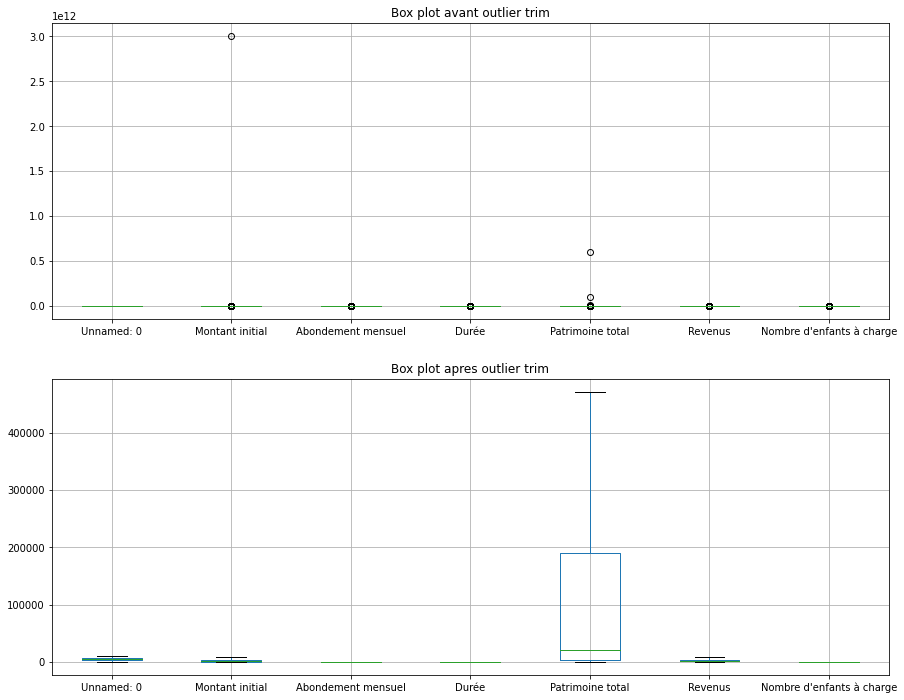

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(15,12))
df[numeric_features].boxplot(ax=axes[0]);
axes[0].set_title("Box plot avant outlier trim")
no_ouliers.boxplot(ax=axes[1])
axes[1].set_title("Box plot apres outlier trim")

In [ ]:
def plot_set_boxplot(plot_list, title):
    fig = make_subplots(
        rows=3, 
        cols=3
    )
    
    traces = [
        go.Box(
            y=df[col], 
            
            name=col
        ) for col in plot_list
    ]

    for i in range(len(traces)):
        fig.append_trace(
            traces[i], 
            (i // 3) + 1, 
            (i % 3) + 1
        )

    fig.update_layout(
        title_text=title,
        height=1000,
       width=1150
    )
    fig.show()

##Data Imputation

In [ ]:
# encode type d'utilisateur
df["Type utilisateur"] = df["Type utilisateur"].map({'Prospect': 0, 'Client': 1})

In [ ]:
#remove Type utilistauer
categorical_features.delete(0)

Index(['Niveau expérience financière', 'Niveau appétence au risque',
       'Niveau capacité de prise de risque', 'Statut marital'],
      dtype='object')

![](https://miro.medium.com/max/3832/1*-ieGos_q5jzLsEy-8uRC6Q.png)


In [ ]:
def impute_categorical_features(df):
    # Impute categorical features with most_frequent value
  for col in categorical_features:
    imputer = SimpleImputer(strategy="most_frequent")
    df[col] = pd.DataFrame(imputer.fit_transform(df[col].values.reshape(-1,1)))
  return df

In [ ]:
df[categorical_features] = impute_categorical_features(df[categorical_features])

In [ ]:
df[categorical_features].isna().sum()

Type utilisateur                      0
Niveau expérience financière          0
Niveau appétence au risque            0
Niveau capacité de prise de risque    0
Statut marital                        0
dtype: int64

In [ ]:
categorical_features

Index(['Type utilisateur', 'Niveau expérience financière',
       'Niveau appétence au risque', 'Niveau capacité de prise de risque',
       'Statut marital'],
      dtype='object')

In [ ]:
#knn imputation
X = df["Type utilisateur"]
y = df[numeric_features[1:]]

In [ ]:
X.values

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# pour savoir quel nombre k choisir pour KNN
numeric_features = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
numeric_features.remove("Type utilisateur")

X = df[numeric_features]
y = df["Type utilisateur"]

from numpy import mean
from numpy import std
strategies = [str(i) for i in [1,3,5,7,9,11,13,18,20,30]]
results = []
for s in strategies:
	# create the modeling pipeline
	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
	# evaluate the model
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
	# store results
	results.append(scores)
	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=strategies, showmeans=True)
plt.show()

In [ ]:
# imputer numeric
imputer =KNNImputer(n_neighbors=3)
df[numeric_features] = pd.DataFrame(imputer.fit_transform(df[numeric_features]),columns=numeric_features)

		

In [ ]:
# discritser les colonnes discrétes
df["Nombre d'enfants à charge"] = df["Nombre d'enfants à charge"].astype(int)
df["Durée"] = df["Durée"].astype(int)

In [ ]:
df.isna().sum()

Unnamed: 0                            0
Montant initial                       0
Abondement mensuel                    0
Durée                                 0
Type utilisateur                      0
Niveau expérience financière          0
Niveau appétence au risque            0
Niveau capacité de prise de risque    0
Patrimoine total                      0
Revenus                               0
Statut marital                        0
Nombre d'enfants à charge             0
dtype: int64

In [ ]:
# save csv checkpoint
#df.to_csv("/content/drive/MyDrive/Mon petit placement/cleaned_csv/Data_clean",index=False)

## Partie Modelisation

In [ ]:
df =pd.read_csv("/content/drive/MyDrive/Mon petit placement/cleaned_csv/Data_clean")

In [ ]:
df[numeric_features]

,Montant initial,Abondement mensuel,Durée,Patrimoine total,Revenus,Nombre d'enfants à charge
0,4.741925e+08,22551.490644,4,1.289913e+08,3754.185338,0
1,5.000000e+02,100.000000,5,0.000000e+00,2000.000000,0
2,4.741925e+08,22551.490644,4,1.289913e+08,3754.185338,0
3,1.000000e+03,100.000000,5,2.000000e+06,56400.000000,3
4,4.000000e+03,0.000000,8,1.000000e+02,100.000000,1
...,...,...,...,...,...,...
9040,5.000000e+03,500.000000,5,1.500000e+06,8000.000000,0
9041,4.741925e+08,22551.490644,4,1.289913e+08,3754.185338,0
9042,2.000000e+02,100.000000,2,1.500000e+03,5000.000000,2
9043,1.000000e+03,100.000000,1,3.400000e+05,3400.000000,2


In [ ]:
df.head()

,Montant initial,Abondement mensuel,Durée,Type utilisateur,Niveau expérience financière,Niveau appétence au risque,Niveau capacité de prise de risque,Patrimoine total,Revenus,Statut marital,Nombre d'enfants à charge
0,4.741925e+08,22551.490644,4,0,initie,dynamique,beaucoup,1.289913e+08,3754.185338,Célibataire,0
1,5.000000e+02,100.000000,5,0,initie,offensif,peu,0.000000e+00,2000.000000,Concubin (e),0
2,4.741925e+08,22551.490644,4,0,initie,dynamique,beaucoup,1.289913e+08,3754.185338,Célibataire,0
3,1.000000e+03,100.000000,5,0,confirme,dynamique,beaucoup,2.000000e+06,56400.000000,Marié(e),3
4,4.000000e+03,0.000000,8,0,confirme,dynamique,peu,1.000000e+02,100.000000,Marié(e),1


In [ ]:
numeric_features = list(df.select_dtypes(include=['int64', 'float64']).columns.values)
numeric_features.remove("Type utilisateur")
categorical_features = df.select_dtypes(include=['object']).columns.values

In [ ]:
numeric_features

['Montant initial',
 'Abondement mensuel',
 'Durée',
 'Patrimoine total',
 'Revenus',
 "Nombre d'enfants à charge"]

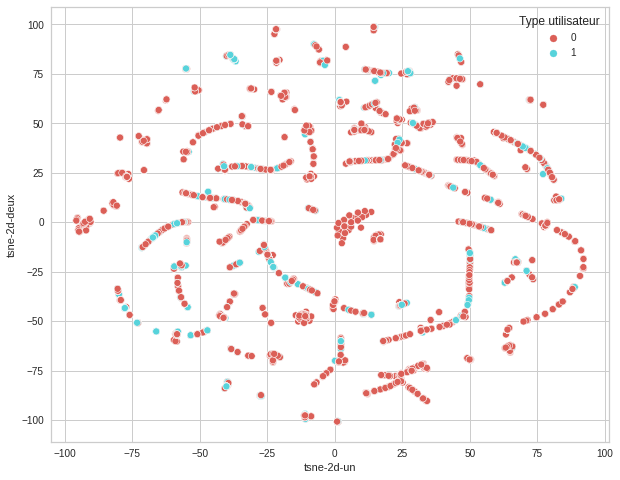

In [ ]:
#T-sne avec rescaling
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=tsne_df,
    x="tsne-2d-un", y="tsne-2d-deux",
    hue="Type utilisateur",
    palette=sns.color_palette("hls", 2),    
    legend="full",
)

In [ ]:
pca_df = df.copy() 

st = StandardScaler()
pca_df[numeric_features] = st.fit_transform(pca_df[numeric_features])


pca = PCA()
pca_results = pca.fit_transform(pca_df[numeric_features])

pca_df['pca-2d-un'] = pca_results[:,0]
pca_df['pca-2d-deux'] = pca_results[:,1]

In [ ]:
#nombre d'observations
n = pca_df[numeric_features].shape[0]
#nombre de variables
p = X.shape[1]
eig = eigval = (n-1)/n*pca.explained_variance_
eigval

array([1.70104293, 1.34837837, 1.02211081, 0.95711504, 0.66242115,
       0.30893169])

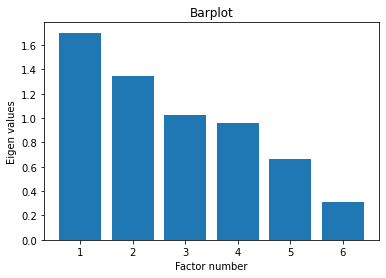

In [ ]:
# barplot des valeurs propres
plt.bar(np.arange(1,p+1),eigval);
plt.title("Barplot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()

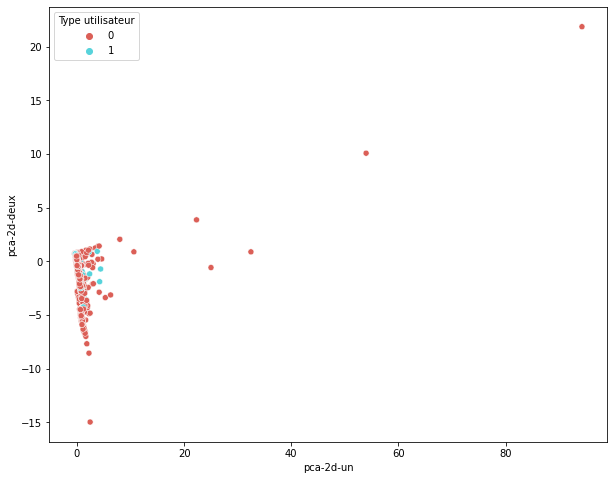

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=pca_df,
    x="pca-2d-un", y="pca-2d-deux",
    hue="Type utilisateur",
    palette=sns.color_palette("hls", 2),    
    legend="full",
)

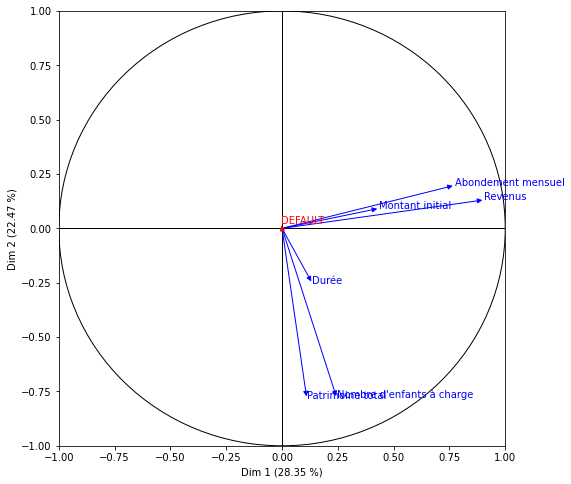

In [ ]:
coord = pca_results

# Matrice de Corrélation
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))

#corrélation de la cible avec les axes factoriels
corSupp = np.zeros((1,p))
for k in range(p):
    corSupp[0,k] = np.corrcoef(y,coord[:,k])[0,1]
corSupp
for k in range(p):
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
#cosinus carré des variables (qualité de représentation)
cos2var = corvar**2
#contributions
ctrvar = cos2var
for k in range(p):
    ctrvar[:,k] = ctrvar[:,k]/eigval[k]
#cercle des corrélations du plan
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des variables actives
for j in range(p):
    plt.annotate(pca_df[numeric_features].columns[j],(corvar[j,0],corvar[j,1]),color='blue')
    plt.annotate("",
              xy=(0, 0), xycoords='data',
              xytext=(corvar[j,0],corvar[j,1]), textcoords='data',
              arrowprops=dict(color='blue',arrowstyle='<|-',
                              connectionstyle="arc3,rad=0."), 
              )
#affiche des variables illustratives (y)
plt.annotate('DEFAULT',(corSupp[0,0],corSupp[0,1]),color='red')
plt.annotate("",
              xy=(0, 0), xycoords='data',
              xytext=(corSupp[0,0],corSupp[0,1]), textcoords='data',
              arrowprops=dict(color='red',arrowstyle='<|-',
                              connectionstyle="arc3,rad=0."), 
              )
#ajouter les axes
plt.plot([-1,1],[0,0],color='black',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='black',linestyle='-',linewidth=1)
#ajouter un cercle
cercle = plt.Circle((0,0),1,color='black',fill=False)
axes.add_artist(cercle)
#affichage
plt.xlabel("Dim 1 (%0.2f %%)"% (pca.explained_variance_ratio_[0]*100))
plt.ylabel("Dim 2 (%0.2f %%)"% (pca.explained_variance_ratio_[1]*100))
plt.show()

#Feature Importance comparé par type d'utlisateur


In [ ]:
def encode_des_variables(df):
  cat_cols = df.select_dtypes(include=['object']).columns.values
  for col in cat_cols:
    if df[col].nunique == 2:
      df[col] = df[col].factorize()[0]
    else:
      df = pd.concat([df,pd.get_dummies(df[col])],axis=1)
      df.drop(columns=[col],inplace=True)
  return df   

In [ ]:
df_encoded = encode_des_variables(df)

In [ ]:
test["Nombre d\'enfants à charge"].value_counts()

0.0    4222
1.0     482
2.0     455
3.0     124
4.0      26
5.0      14
Name: Nombre d'enfants à charge, dtype: int64

In [ ]:
df_encoded.head()

,Montant initial,Abondement mensuel,Durée,Type utilisateur,Patrimoine total,Revenus,Nombre d'enfants à charge,confirme,debutant,expert,initie,dynamique,equilibre,offensif,prudent,aucun,beaucoup,normal,peu,Concubin (e),Célibataire,Divorcé(e),Marié(e),Pacsé(e),Séparé(e) de corps,Veuf(ve)
0,4.741925e+08,22551.490644,4.607363,0,1.289913e+08,3754.185338,0.36408,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,5.000000e+02,100.000000,5.000000,0,0.000000e+00,2000.000000,0.00000,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
2,4.741925e+08,22551.490644,4.607363,0,1.289913e+08,3754.185338,0.36408,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,1.000000e+03,100.000000,5.000000,0,2.000000e+06,56400.000000,3.00000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,4.000000e+03,0.000000,8.000000,0,1.000000e+02,100.000000,1.00000,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [ ]:
# save checkpoint
#df_encoded.to_csv("/content/drive/MyDrive/Mon petit placement/cleaned_csv/Data_clean_encoded",index= False)

In [ ]:
df_encoded = pd.read_csv("/content/drive/MyDrive/Mon petit placement/cleaned_csv/Data_clean_encoded")

In [ ]:
df_encoded.head()

,Montant initial,Abondement mensuel,Durée,Type utilisateur,Patrimoine total,Revenus,Nombre d'enfants à charge,confirme,debutant,expert,initie,dynamique,equilibre,offensif,prudent,aucun,beaucoup,normal,peu,Concubin (e),Célibataire,Divorcé(e),Marié(e),Pacsé(e),Séparé(e) de corps,Veuf(ve)
0,4.741925e+08,22551.490644,4,0,1.289913e+08,3754.185338,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,5.000000e+02,100.000000,5,0,0.000000e+00,2000.000000,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
2,4.741925e+08,22551.490644,4,0,1.289913e+08,3754.185338,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,1.000000e+03,100.000000,5,0,2.000000e+06,56400.000000,3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,4.000000e+03,0.000000,8,0,1.000000e+02,100.000000,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [ ]:
#!pip install yellowbrick --upgrade

In [ ]:
X= df_encoded.drop(columns=["Type utilisateur"])
y =df_encoded["Type utilisateur"]

In [ ]:
# imputation des features numérique

imputer = StandardScaler()
X[numeric_features] = imputer.fit_transform(X[numeric_features])

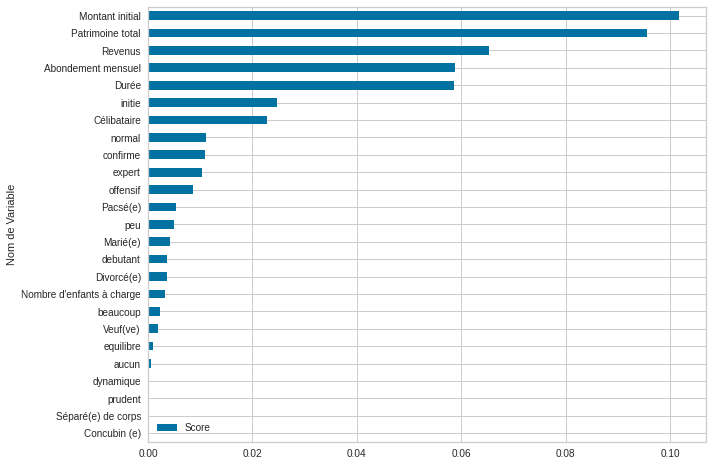

In [ ]:
 (Filter method)
selected_features = SelectKBest(mutual_info_classif).fit(X, y)
pd.DataFrame({"Nom de Variable" : X.columns , "Score": selected_features.scores_}).sort_values(by ="Score",ascending=True).plot.barh(x ="Nom de Variable",y="Score",figsize =(10,8))

In [ ]:
# Methode Wrapper
rfe = RFE(estimator=RandomForestClassifier())
rfe.fit(X,y)

In [ ]:
pd.DataFrame({"Nom de Variable" : X.columns , "Rank": rfe.ranking_}).sort_values(by ="Rank",ascending=True)

,Nom de Variable,Rank
0,Montant initial,1
1,Abondement mensuel,1
2,Durée,1
3,Patrimoine total,1
4,Revenus,1
5,Nombre d'enfants à charge,1
19,Célibataire,1
16,normal,1
8,expert,1
9,initie,1


#Partie Clustering 

In [ ]:
df_Kmeans = pd.concat([X,y],axis=1)

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

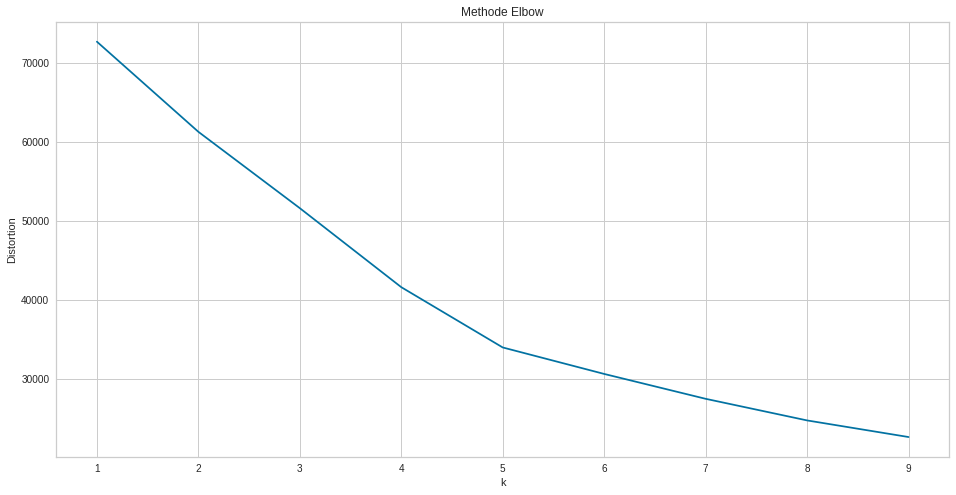

In [ ]:
# avant k-mean on peut appliquer methode elbow pour avoir une idée de nombre k de cluster
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_Kmeans)
    distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(16,8)) 
plt.plot(K, distortions, 'bx-')
plt.xlabel('k') ; 
plt.ylabel('Distortion') 
plt.title('Methode Elbow') 
plt.show() 

In [ ]:
km = KMeans(n_clusters=5,init="k-means++").fit(df_Kmeans)
y_predicted = km.fit_predict(df_Kmeans)
df_Kmeans["Cluster"] = y_predicted

In [ ]:
pd.crosstab(df_Kmeans["Type utilisateur"],df_Kmeans["Cluster"])

Cluster,0,1,2,3,4
Type utilisateur,,,,,
0,6821,1,295,875,1
1,812,0,0,240,0


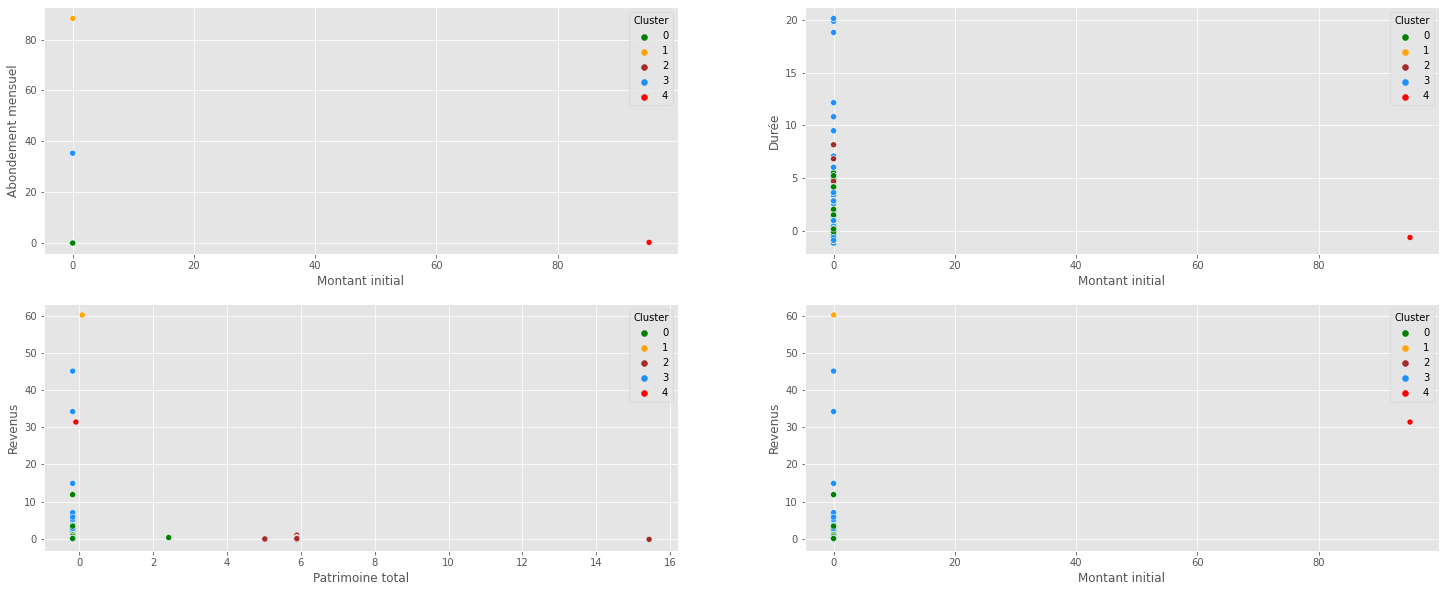

In [ ]:
plt.rcParams['axes.grid'] = True
plt.style.use("ggplot")
fig,axe = plt.subplots(2,2,figsize=(25,10))
sns.scatterplot(data=df_Kmeans,x='Montant initial',y='Abondement mensuel',hue="Cluster",ax=axe[0,0],palette=['green','orange','brown','dodgerblue','red'])
sns.scatterplot(data=df_Kmeans,x='Montant initial',y='Durée',hue="Cluster",ax=axe[0,1],palette=['green','orange','brown','dodgerblue','red'])
sns.scatterplot(data=df_Kmeans,x='Patrimoine total',y='Revenus',hue="Cluster",ax=axe[1,0],palette=['green','orange','brown','dodgerblue','red'])
sns.scatterplot(data=df_Kmeans,x='Montant initial',y='Revenus',hue="Cluster",ax=axe[1,1],palette=['green','orange','brown','dodgerblue','red'])